In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

%matplotlib inline
%matplotlib notebook

from glob import glob

timer = cy.timing.Timer()
time = timer.time

In [2]:
data_dir = '/data/user/cjchen/csky/analyses/online_GRECO/version-002-p04'
data_filenames = sorted(glob(data_dir + '/IC86_20*.data_with_angErr.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged_with_angErr.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

min_log_e = 1.0
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 5, 30+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]

In [3]:
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.4', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/cjchen/2020-2021/Spring2021/0118-0122')
ana = cy.get_analysis(cy.selections.repo, dataset_spec, dir=ana_dir, load_sig=True)

Setting up Analysis for:
greco_v2.4
Setting up greco_v2.4...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [ ]:
# ras = df['ra']
# decs = df['dec']
# delta_t = df['$t_2$']
# delta_t = np.minimum(delta_t, np.ones_like(delta_t)*max_time_window)

# conf = {'extended': True,
#        'space': "ps",
#         'time': "transient",
#         'sig': 'transient',
#        }

# src = cy.utils.Sources(ra=np.radians(ras), 
#                        dec=np.radians(decs), 
#                        mjd=df['mjd'], 
#                        sigma_t=np.zeros_like(delta_t), 
#                        t_100=delta_t)

# cy.CONF['src'] = src
# cy.CONF['mp_cpus'] = 10

In [4]:
conf = {
    'ana': ana,
    
    'extended': True,
        }
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 1
cy.CONF['TRUTH'] = False

Test load probs

In [5]:
grbweb = pd.read_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/grbweb/grb_grbweb.pkl")
# probs = hp.read_map("/home/cjchen/2020-2021/Spring2021/greco_grb/data/gbm/healpix/glg_healpix_all_bn120426585_v00.fit")
# grbweb.loc[grbweb['grb_name_GBM'] == "GRB120426585"]

probs = hp.read_map("/home/cjchen/2020-2021/Spring2021/greco_grb/data/gbm/healpix/glg_healpix_all_bn180423033_v00.fit")
grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"]


,grb_name,grb_name_GBM,ra,dec,mjd_start,t100,t90,gbm,source_uncertainty,redshift,t_center
342,GRB180423A,GRB180423033,208.68,9.84,58231.032586,0.000634,0.000634,1,4.794662,NaN,58231.032903


In [6]:
probs_copy = np.sort(probs)
cdf = np.cumsum(probs_copy)
probs90 = probs_copy[(np.abs(cdf - 0.1)).argmin()]

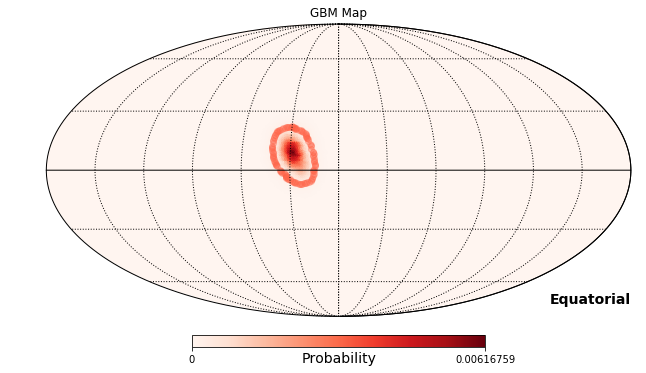

In [7]:
cmap = cm.Reds
cmap.set_under("w")

# pixels = np.where((0 != probs) & (9.5e-7 < probs) & (probs < 1e-6))[0]  # Get the circle around the GBM burst
pixels = np.where((probs > 0.95*probs90) & (probs < 1.05*probs90))[0]

THETA, PHI = hp.pixelfunc.pix2ang(128, pixels)  # Get all the angles for this circle
pixarea = hp.pixelfunc.nside2pixarea(128, degrees=True)
hp.mollview(probs/pixarea, cbar=True, coord='C',unit=r'Probability',rot=180, cmap=cmap, min=0, max=np.max(probs/pixarea), title='GBM Map')
hp.graticule()

hp.projscatter(THETA, PHI, color='tomato', alpha=0.3)


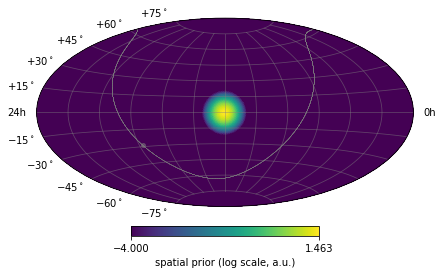

In [8]:
m = hl.heal.hist(128, [0], [np.pi]).smoothing(np.radians(10)).normalize()
m.map = np.maximum(1e-4, m.map)
fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(m.map), n_ticks=2)
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'spatial prior (log scale, a.u.)')
plt.tight_layout()

In [28]:
ra = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].ra
dec = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].dec
mjd = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].mjd_start
mjd

342    58231.032586
Name: mjd_start, dtype: float64

342    208.68
Name: ra, dtype: float64

In [9]:
dec85 = np.radians(85)
spt_conf = {
    't0_min': 58232.1,
    't0_max': 58232.2,
    
}
sptr = cy.get_spatial_prior_trial_runner(llh_priors=hp.ud_grade(m.map, 64), min_dec=-dec85, max_dec=dec85)


In [10]:
sptr

In [12]:
result = sptr.get_one_fit(10, seed=1, mp_cpus=5, logging=True)

Scanning 48984 locations using 5 cores:


Process Process-1:
Traceback (most recent call last):
Process Process-2:
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cjchen/csky/csky/csky/trial.py", line 1937, in get_partial_scan_from_trial
    initial_selector = self.get_selector(np.unique(scan_dec))
Traceback (most recent call last):
  File "/home/cjchen/csky/csky/csky/conf.py", line 350, in get_selector
    src = merge_src_tr(src)
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Process-3:
  File "/home/cjchen/csky/csky/csky/conf.py", line 333, in merge_src_tr
    for key in src_tr.keys():
  File "/cvmfs/icecube.opensciencegrid.org/py3-

          0/48984 coordinates complete...

  File "/home/cjchen/csky/csky/csky/conf.py", line 350, in get_selector
    src = merge_src_tr(src)
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Process-4:
  File "/home/cjchen/csky/csky/csky/conf.py", line 333, in merge_src_tr
    for key in src_tr.keys():
AttributeError: 'bool' object has no attribute 'keys'
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cjchen/csky/csky/csky/trial.py", line 1937, in get_partial_scan_from_trial
    initial_selector = self.get_selector(np.unique(scan_dec))
Traceback (most recent call last):
  File "/home/cjchen/csky/csky/csky/conf.py", line 350, in get_sel

          0/48984 coordinates complete...

UnboundLocalError: local variable 'e' referenced before assignment

In [13]:
trial = sptr.get_one_trial(20, seed=1)
trial

SpatialPriorTrial(evss=[[Events(886274 items | columns: dec, idx, inj, log10energy, ra, sigma, sindec), Events(20 items | columns: dec, idx, inj, log10energy, ra, sigma, sindec)]], n_exs=[0], ra=array([2.96978681]), dec=array([0.01041686]))

In [14]:
np.degrees([trial.ra, trial.dec]).ravel()

array([170.15625   ,   0.59684183])

In [15]:
sstr = cy.get_sky_scan_trial_runner(nside=64, min_dec=-dec85, max_dec=dec85)

In [16]:
%time scan = sstr.get_one_scan_from_trial(trial, mp_cpus=5, logging=True)

Scanning 48984 locations using 5 cores:
       2794/48984 coordinates complete...

Process Process-9:
Process Process-10:
Traceback (most recent call last):
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cjchen/csky/csky/csky/trial.py", line 1965, in get_partial_scan_from_trial
    next_result = tr.modify_ra(sra).get_one_fit_from_trial((e, n), **fitter_args)
  File "/home/cjchen/csky/csky/csky/trial.py", line 867, in get_one_fit_from_trial
    fit = llh.fit(**kw)


UnboundLocalError: local variable 'e' referenced before assignment

Process Process-7:
  File "/home/cjchen/csky/csky/csky/llh.py", line 478, in fit
    rc = get_raw_calc(seed, use_prior=seed_with_prior)
  File "/home/cjchen/csky/csky/csky/llh.py", line 420, in get_raw_calc
    return self.get_raw_calc(prior=pr, taylor_tol=taylor_tol, _masks=_masks, **kw)
  File "/home/cjchen/csky/csky/csky/llh.py", line 234, in get_raw_calc
    counts, Xs, nsmax = self.get_counts_Xs_nsmax(_masks=_masks, **params)
  File "/home/cjchen/csky/csky/csky/llh.py", line 668, in get_counts_Xs_nsmax
    return self.get_counts_Xs_nsmax_acc(_masks=_masks, **params)[:-1]
  File "/home/cjchen/csky/csky/csky/llh.py", line 638, in get_counts_Xs_nsmax_acc
    W, W_sigsub = W[mask], W_sigsub[mask]
Traceback (most recent call last):
KeyboardInterrupt
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/R

  File "/home/cjchen/csky/csky/csky/llh.py", line 423, in minus_llh__opt_ns
    rc = get_raw_calc(x, unlog=True)
  File "/home/cjchen/csky/csky/csky/llh.py", line 420, in get_raw_calc
    return self.get_raw_calc(prior=pr, taylor_tol=taylor_tol, _masks=_masks, **kw)
  File "/home/cjchen/csky/csky/csky/llh.py", line 234, in get_raw_calc
    counts, Xs, nsmax = self.get_counts_Xs_nsmax(_masks=_masks, **params)
  File "/home/cjchen/csky/csky/csky/llh.py", line 668, in get_counts_Xs_nsmax
    return self.get_counts_Xs_nsmax_acc(_masks=_masks, **params)[:-1]
  File "/home/cjchen/csky/csky/csky/llh.py", line 632, in get_counts_Xs_nsmax_acc
    W, W_sigsub = evaluator(_mask=_mask, **params)
  File "/home/cjchen/csky/csky/csky/pdf.py", line 2261, in __call__
    this_W, this_W_sigsub = evaluator(_mask=_mask, **params)
  File "/home/cjchen/csky/csky/csky/pdf.py", line 2773, in __call__
    r1 = self.get_logW(gamma1, _mask=_mask)
  File "/home/cjchen/csky/csky/csky/pdf.py", line 2748, in get_log

In [ ]:
scan.shape